# Предсказание стоимости жилья / Predicting the cost of housing

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

ENG:

In the project, you need to train a linear regression model on housing data in California in 1990. Based on the data, it is necessary to predict the median cost of a house in a residential area. Train the model and make predictions on the test sample. To assess the quality of the model, use the RMSE, MAE and R2 metrics.

## Подготовка данных / Data preparation

### Библиотеки / Libraries

In [ ]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import  pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler,OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
import seaborn as sns

RANDOM=1224

* longitude — широта;
*latitude — долгота;
*housing_median_age — медианный возраст жителей жилого массива;
*total_rooms — общее количество комнат в домах жилого массива;
*total_bedrooms — общее количество спален в домах жилого массива;
*population — количество человек, которые проживают в жилом массиве;
*households — количество домовладений в жилом массиве;
*median_income — медианный доход жителей жилого массива;
*median_house_value — медианная стоимость дома в жилом массиве;
*ocean_proximity — близость к океану.

### Создадим ссесию и выведем первые 5 строк / Create a session and output the first 5 lines

In [ ]:
spark=SparkSession.builder.appName('project').getOrCreate()

In [ ]:

df=spark.read.load('/datasets/housing.csv',sep=',',format='csv',inferSchema=True,header='true')
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

### Проверим тип данных и  преобразуем / Let's check the data type and convert

In [ ]:
df.select(['housing_median_age','population','households','median_income','total_rooms','total_bedrooms']).describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|housing_median_age|        population|       households|     median_income|       total_rooms|    total_bedrooms|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             20640|             20640|            20640|             20640|             20640|             20433|
|   mean|28.639486434108527|1425.4767441860465|499.5396802325581|3.8706710029070246|2635.7630813953488| 537.8705525375618|
| stddev| 12.58555761211163|  1132.46212176534|382.3297528316098| 1.899821717945263|2181.6152515827944|421.38507007403115|
|    min|               1.0|               3.0|              1.0|            0.4999|               2.0|               1.0|
|    max|              52.0|           35682.0|           6082.0|           15.0001|           39320.0|            6445.0|
+-------+-------

In [ ]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [ ]:
for i in df.columns:
    
    print(i,' - ',f'Количество уникальных значений : {df.select(i).distinct().count()}')
    

longitude  -  Количество уникальных значений : 844


latitude  -  Количество уникальных значений : 862


housing_median_age  -  Количество уникальных значений : 52


total_rooms  -  Количество уникальных значений : 5926


total_bedrooms  -  Количество уникальных значений : 1924


population  -  Количество уникальных значений : 3888


households  -  Количество уникальных значений : 1815


median_income  -  Количество уникальных значений : 12928


median_house_value  -  Количество уникальных значений : 3842


ocean_proximity  -  Количество уникальных значений : 5


In [ ]:
#df.withColumn('ocean_proximity',F.col('ocean_proximity').cast('Integer'))
for i in df.columns[:-1]:
    df=df.withColumn(i,F.col(i).cast('double'))

## Предобработка данных / Data preprocessing

### Иследовательский анализ / Research analysis

In [1]:
df.select([F.count(F.when(F.isnull(i),i)).alias(i) for i in df.columns]).show()

NameError: ignored

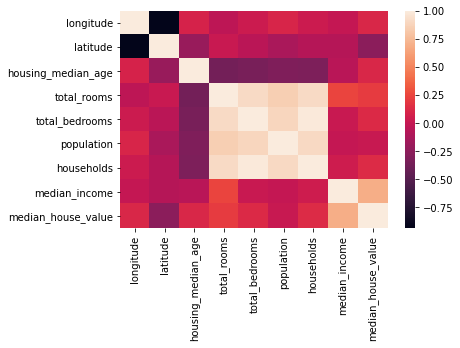

In [ ]:
data=df.limit(10000).toPandas()
corr=data.corr()
sns.heatmap(corr);

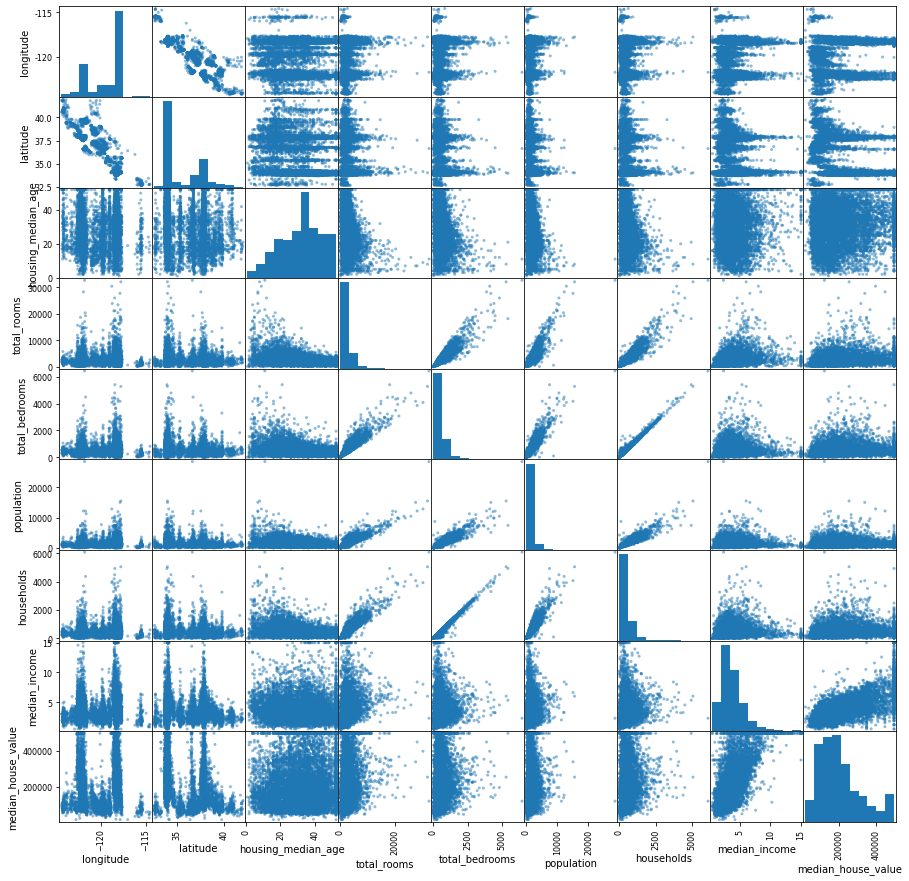

In [ ]:

pd.plotting.scatter_matrix(data, figsize=(15, 15)); 

### Заметка / Note : 

Построив несколько графиков для того что бы определить взаимосвязь между количеством спален и другими признаками, мы можем увидеть сильну. кореляцию с параметрами:
       
- Количество домов
- Количество жителей
- Общее количество комнат

ENG:

Having built several graphs in order to determine the relationship between the number of bedrooms and other signs, we can see the strong. correlation with parameters:

- Number of houses
- Number of inhabitants
- Total number of rooms

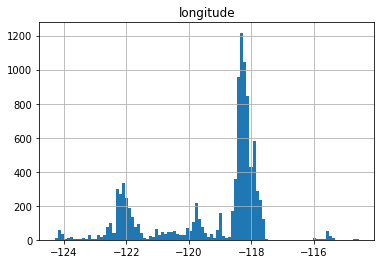

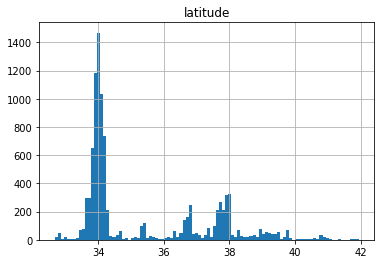

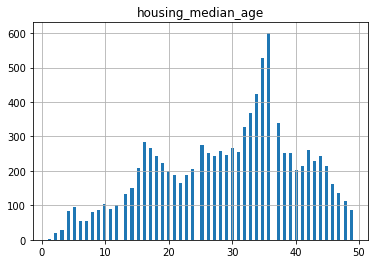

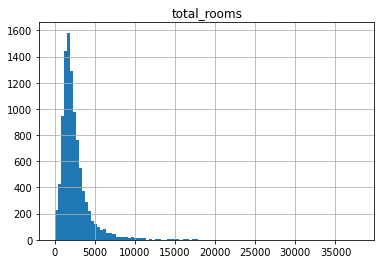

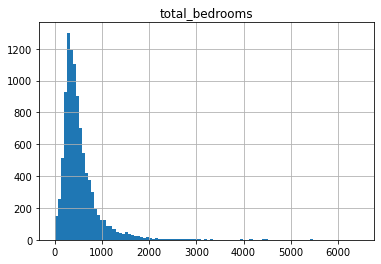

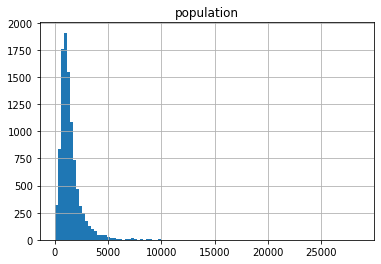

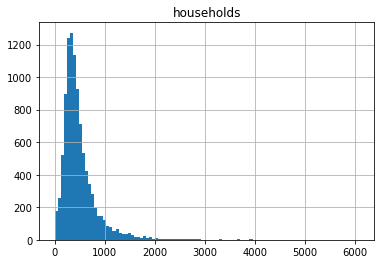

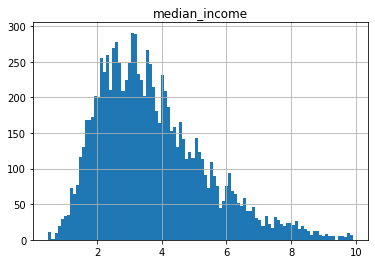

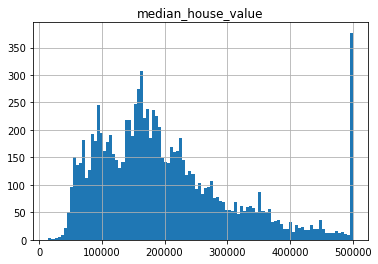

In [ ]:
for i in df.columns[:-1]:
    bath=df.limit(10000).select(i).toPandas()
    bath.hist(bins=100);

In [ ]:
df.count()

20640

In [ ]:
df=df.filter((df['housing_median_age']<50) & (df['median_income']<10))

In [ ]:
df.count()

18920

Заменим на медианное значение /  Change for median 

In [ ]:
median=pd.Series([float(i[-1]) for i in df.select(df['total_bedrooms']/df['total_rooms']).filter(df['total_bedrooms']!=0).collect()]).median()

In [ ]:
#avg_bath=df.select(F.avg('total_bedrooms')).collect()[0][0]
df = df.withColumn('total_bedrooms', F.when(F.col('total_bedrooms').isNull(), F.col('total_rooms') * median).otherwise(F.col('total_bedrooms')))

In [ ]:
#df=df.drop(F.col('longitude'))
#df=df.drop(F.col('latitude'))

### Делим на выборки и преобразовываем данные в них / Divide into samples and convert the data into them

In [ ]:
category_cols=['ocean_proximity']
numeric_cols=['housing_median_age','population','households','median_income','total_rooms','total_bedrooms']
target='median_house_value'
features=['category_features', 'numeric_features_scalled']

In [ ]:

train_data,test_data=df.randomSplit([.8,.2],seed=RANDOM)
print(train_data.count(),test_data.count())

15091 3829


In [ ]:

features=['category_features', 'numeric_features_scalled']
indexer = StringIndexer(inputCols=[i for i in category_cols], outputCols=[col + '_indx' for col in category_cols])
encoder = OneHotEncoder(inputCols=[col + '_indx' for col in category_cols], outputCols=[col + '_encod' for col in category_cols])
category_features = VectorAssembler(inputCols=[col + '_encod' for col in category_cols], outputCol='category_features')
numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol='numeric_features')
scaler = StandardScaler(inputCol='numeric_features', outputCol='numeric_features_scalled')
final_features = VectorAssembler(inputCols=features, outputCol='final_features')

indexed_data = indexer.fit(train_data)
train_data=indexed_data.transform(train_data)
test_data=indexed_data.transform(test_data)


encoded_data = encoder.fit(train_data)
train_data=encoded_data.transform(train_data)
test_data=encoded_data.transform(test_data)


train_data=category_features.transform(train_data)
test_data=category_features.transform(test_data)


train_data=numeric_assembler.transform(train_data)
test_data=numeric_assembler.transform(test_data)

scaler_model = scaler.fit(train_data)
train_data=scaler_model.transform(train_data)
test_data=scaler_model.transform(test_data)

train_data=final_features.transform(train_data)
test_data=final_features.transform(test_data)




In [ ]:
train_data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- ocean_proximity_indx: double (nullable = false)
 |-- ocean_proximity_encod: vector (nullable = true)
 |-- category_features: vector (nullable = true)
 |-- numeric_features: vector (nullable = true)
 |-- numeric_features_scalled: vector (nullable = true)
 |-- final_features: vector (nullable = true)



## Обучение моделей / Model training

### Обучаем модель / Train model

#### Функция для обучения / Function for study

In [ ]:
def train(train_data, test_data, features_col):
    
    model = LinearRegression(labelCol='median_house_value',featuresCol=features_col)
    model_fit = model.fit(train_data)
    predictions = model_fit.transform(test_data)
    
    mae=RegressionEvaluator(labelCol='median_house_value',metricName='mae').evaluate(predictions)
    r2=RegressionEvaluator(labelCol='median_house_value',metricName='r2').evaluate(predictions)
    rmse=RegressionEvaluator(labelCol='median_house_value',metricName='rmse').evaluate(predictions)
    
    print('MAE построенной на всех признакаъ :',mae)
    print('RMSE построенной на всех признакаъ :',rmse)
    print('R2 построенной на всех признакаъ :',r2)
    
    

In [ ]:
train(train_data,test_data,'final_features')

23/02/17 18:36:35 WARN Instrumentation: [ca811769] regParam is zero, which might cause numerical instability and overfitting.
23/02/17 18:36:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/17 18:36:36 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/02/17 18:36:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/17 18:36:36 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


MAE построенной на всех признакаъ : 48485.07108456319
RMSE построенной на всех признакаъ : 67205.40683967526
R2 построенной на всех признакаъ : 0.6234835748540846


#### Только числовые признаки / Numeric signs only

In [ ]:
train(train_data,test_data,'numeric_features_scalled')

23/02/17 18:36:41 WARN Instrumentation: [243009d9] regParam is zero, which might cause numerical instability and overfitting.


MAE построенной на всех признакаъ : 53248.0883898316
RMSE построенной на всех признакаъ : 72761.62204574233
R2 построенной на всех признакаъ : 0.5586529361716074


# Анализ результатов / Analysis of results

Если смотреть по резульатам то разницы как таковой нету ,видно что в первом случае когда мы обучали на всех данных модельнемного хуже,чем во втором случае ,но в любом случае результаты ужасные в обоих случаях,и мне кажеться здесь нужно проводить более глубокую подготовку признаков.Так как думаю что здесь много шумов. / If you look at the results, there is no difference as such, it is clear that in the first case, when we trained on all the data of the model, it is much worse than in the second case, but in any case, the results are terrible in both cases, and it seems to me that a deeper preparation of the signs should be carried out here.Since I think there is a lot of noise here.